=== E-commerce Return Rate Analysis ===

Generating sample data...

Cleaning data...
Data Cleaning Summary:
Original shape: (10000, 11)
Removed 0 null values
Removed 100 outliers in order_value
Final shape: (9900, 11)

Analyzing return rates...
Overall Return Rate: 17.63%

=== Return Rates by Category ===
               Return_Rate  Total_Orders  Total_Returns
category                                               
Clothing              29.9          1415            423
Electronics           21.2          1405            298
Books                 15.1          1422            215
Home & Garden         15.0          1377            207
Sports                14.5          1455            211
Beauty                13.8          1409            195
Toys                  13.8          1417            196

=== Return Rates by Supplier ===
           Return_Rate  Total_Orders  Total_Returns
supplier                                           
SupplierC         25.9          1895            491

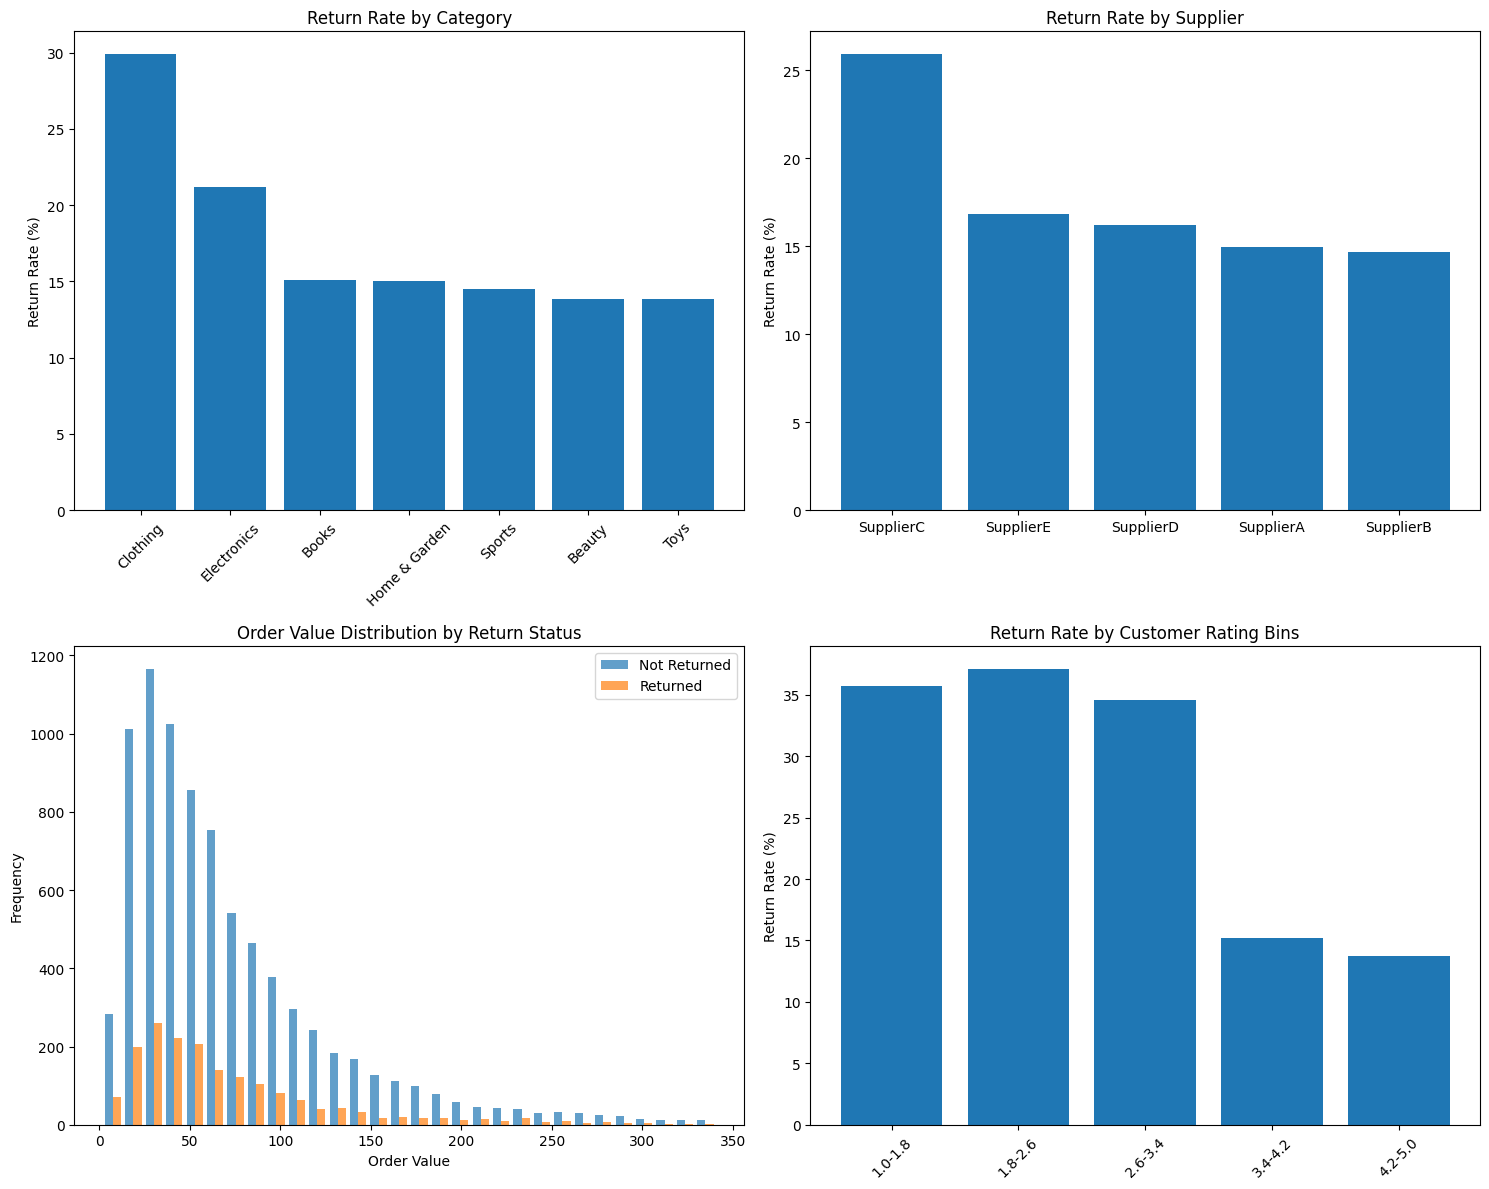

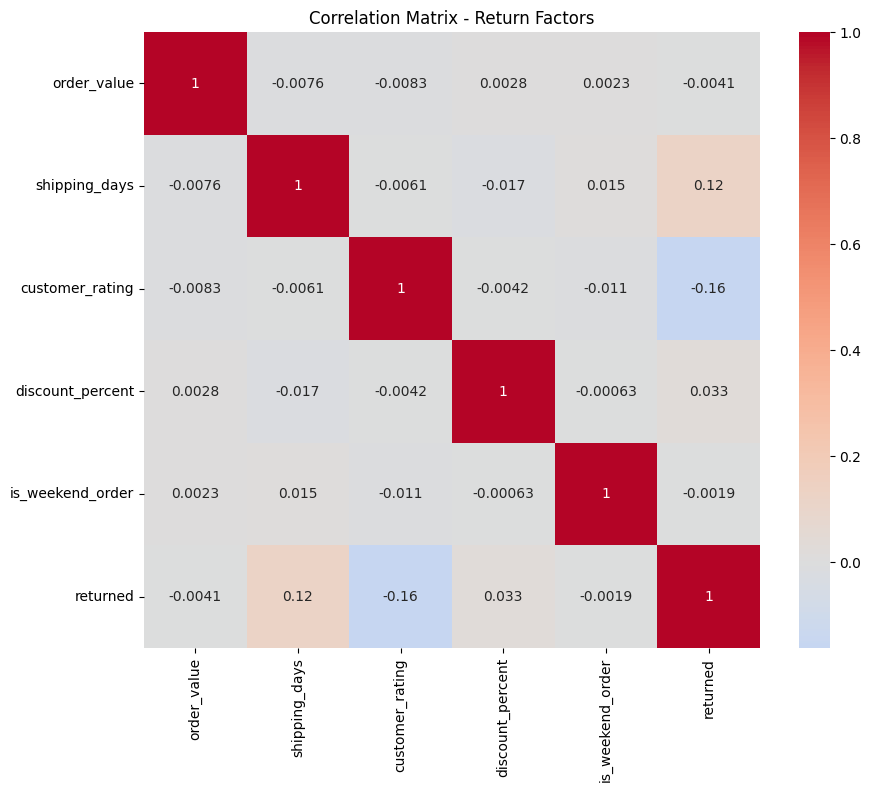


Training prediction model...
=== Model Performance ===
ROC AUC Score: 0.679

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1631
           1       0.17      0.00      0.01       349

    accuracy                           0.82      1980
   macro avg       0.50      0.50      0.45      1980
weighted avg       0.71      0.82      0.74      1980


=== Feature Importance ===
                      feature  importance
10                 low_rating    0.449940
5               shipping_days    0.358189
0            category_encoded    0.091397
12              high_discount    0.088283
1            supplier_encoded    0.063306
2   marketing_channel_encoded    0.053321
9            high_value_order    0.033594
4                 order_value    0.030727
6             customer_rating    0.030360
11              long_shipping    0.026138
7            discount_percent    0.014407
8            is_weekend_order    0.01317

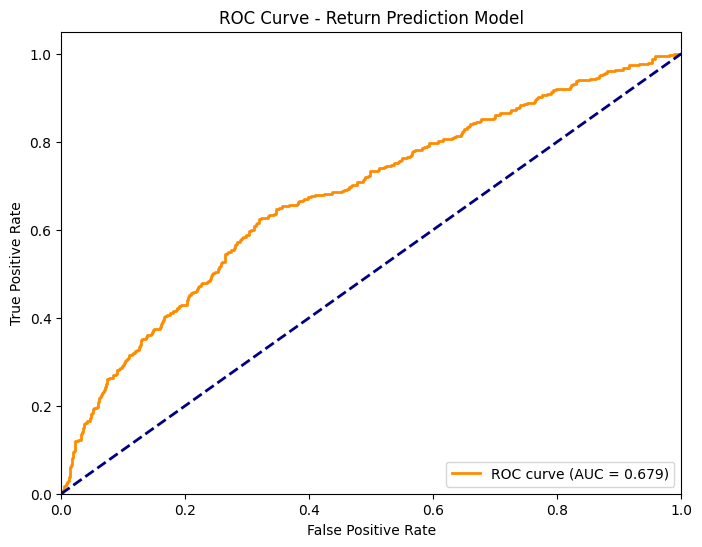


Identifying high-risk products...
=== High Risk Products (Risk Score >= 0.25) ===
Total high-risk orders: 1647
Percentage of total orders: 16.64%

=== High Risk Summary by Category & Supplier ===
                   return_risk_score       order_value
                                mean count        mean
category supplier                                     
Beauty   SupplierA             0.374    48      81.089
         SupplierB             0.374    46      79.454
         SupplierC             0.364    44      83.319
         SupplierD             0.376    56      80.460
         SupplierE             0.367    70      82.083
Books    SupplierA             0.367    43      75.560
         SupplierB             0.367    65      65.930
         SupplierC             0.356    61      69.432
         SupplierD             0.379    58      64.591
         SupplierE             0.382    60      71.135

Saving results...
High-risk products saved to ecommerce_return_analysis_high_risk_produ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

class EcommerceReturnAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = LogisticRegression(random_state=42)
        self.label_encoders = {}
        self.data = None

    def generate_sample_data(self, n_orders=10000):
        """Generate realistic sample e-commerce data for demonstration"""
        np.random.seed(42)

        categories = ['Electronics', 'Clothing', 'Home & Garden', 'Books', 'Sports', 'Beauty', 'Toys']
        suppliers = ['SupplierA', 'SupplierB', 'SupplierC', 'SupplierD', 'SupplierE']
        channels = ['Organic Search', 'Paid Search', 'Social Media', 'Email', 'Direct', 'Affiliate']
        regions = ['North', 'South', 'East', 'West', 'Central']

        data = {
            'order_id': range(1, n_orders + 1),
            'category': np.random.choice(categories, n_orders),
            'supplier': np.random.choice(suppliers, n_orders),
            'marketing_channel': np.random.choice(channels, n_orders),
            'region': np.random.choice(regions, n_orders),
            'order_value': np.random.lognormal(mean=4, sigma=0.8, size=n_orders),
            'shipping_days': np.random.randint(1, 15, n_orders),
            'customer_rating': np.random.normal(4.2, 0.8, n_orders),
            'discount_percent': np.random.exponential(scale=10, size=n_orders),
            'is_weekend_order': np.random.choice([0, 1], n_orders, p=[0.7, 0.3])
        }

        # Create return probability based on realistic factors
        return_prob = (
            0.05 +  # Base return rate
            (data['category'] == 'Clothing').astype(int) * 0.15 +  # Clothing higher return
            (data['category'] == 'Electronics').astype(int) * 0.08 +
            (data['supplier'] == 'SupplierC').astype(int) * 0.10 +  # Poor quality supplier
            (data['customer_rating'] < 3.5).astype(int) * 0.20 +  # Low rating = higher return
            (data['shipping_days'] > 10).astype(int) * 0.12 +  # Long shipping = higher return
            (data['discount_percent'] > 30).astype(int) * 0.08 +  # High discount = impulse buy
            np.random.normal(0, 0.05, n_orders)  # Random noise
        )

        # Ensure probabilities are between 0 and 1
        return_prob = np.clip(return_prob, 0, 1)
        data['returned'] = np.random.binomial(1, return_prob, n_orders)

        self.data = pd.DataFrame(data)
        return self.data

    def clean_data(self):
        """Clean and prepare data for analysis"""
        if self.data is None:
            raise ValueError("No data loaded. Please load or generate data first.")

        print("Data Cleaning Summary:")
        print(f"Original shape: {self.data.shape}")

        # Handle missing values
        initial_nulls = self.data.isnull().sum().sum()
        self.data = self.data.dropna()
        print(f"Removed {initial_nulls} null values")

        # Remove outliers for order_value (beyond 99th percentile)
        q99 = self.data['order_value'].quantile(0.99)
        outliers = len(self.data[self.data['order_value'] > q99])
        self.data = self.data[self.data['order_value'] <= q99]
        print(f"Removed {outliers} outliers in order_value")

        # Cap customer rating between 1 and 5
        self.data['customer_rating'] = np.clip(self.data['customer_rating'], 1, 5)

        # Cap discount percentage at 100%
        self.data['discount_percent'] = np.clip(self.data['discount_percent'], 0, 100)

        print(f"Final shape: {self.data.shape}")
        return self.data

    def analyze_return_rates(self):
        """Analyze return rates by different dimensions"""
        if self.data is None:
            raise ValueError("No data loaded.")

        overall_return_rate = self.data['returned'].mean() * 100
        print(f"Overall Return Rate: {overall_return_rate:.2f}%")

        # Return rates by category
        category_returns = self.data.groupby('category').agg({
            'returned': ['mean', 'count', 'sum']
        }).round(3)
        category_returns.columns = ['Return_Rate', 'Total_Orders', 'Total_Returns']
        category_returns['Return_Rate'] *= 100
        category_returns = category_returns.sort_values('Return_Rate', ascending=False)

        print("\n=== Return Rates by Category ===")
        print(category_returns)

        # Return rates by supplier
        supplier_returns = self.data.groupby('supplier').agg({
            'returned': ['mean', 'count', 'sum']
        }).round(3)
        supplier_returns.columns = ['Return_Rate', 'Total_Orders', 'Total_Returns']
        supplier_returns['Return_Rate'] *= 100
        supplier_returns = supplier_returns.sort_values('Return_Rate', ascending=False)

        print("\n=== Return Rates by Supplier ===")
        print(supplier_returns)

        # Return rates by marketing channel
        channel_returns = self.data.groupby('marketing_channel').agg({
            'returned': ['mean', 'count', 'sum']
        }).round(3)
        channel_returns.columns = ['Return_Rate', 'Total_Orders', 'Total_Returns']
        channel_returns['Return_Rate'] *= 100
        channel_returns = channel_returns.sort_values('Return_Rate', ascending=False)

        print("\n=== Return Rates by Marketing Channel ===")
        print(channel_returns)

        # Return rates by region
        region_returns = self.data.groupby('region').agg({
            'returned': ['mean', 'count', 'sum']
        }).round(3)
        region_returns.columns = ['Return_Rate', 'Total_Orders', 'Total_Returns']
        region_returns['Return_Rate'] *= 100
        region_returns = region_returns.sort_values('Return_Rate', ascending=False)

        print("\n=== Return Rates by Region ===")
        print(region_returns)

        return {
            'category': category_returns,
            'supplier': supplier_returns,
            'channel': channel_returns,
            'region': region_returns
        }

    def create_visualizations(self):
        """Create visualizations for return analysis"""
        if self.data is None:
            raise ValueError("No data loaded.")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Return rate by category
        category_returns = self.data.groupby('category')['returned'].mean().sort_values(ascending=False)
        axes[0,0].bar(category_returns.index, category_returns.values * 100)
        axes[0,0].set_title('Return Rate by Category')
        axes[0,0].set_ylabel('Return Rate (%)')
        axes[0,0].tick_params(axis='x', rotation=45)

        # Return rate by supplier
        supplier_returns = self.data.groupby('supplier')['returned'].mean().sort_values(ascending=False)
        axes[0,1].bar(supplier_returns.index, supplier_returns.values * 100)
        axes[0,1].set_title('Return Rate by Supplier')
        axes[0,1].set_ylabel('Return Rate (%)')

        # Order value distribution by return status
        returned_orders = self.data[self.data['returned'] == 1]['order_value']
        not_returned = self.data[self.data['returned'] == 0]['order_value']
        axes[1,0].hist([not_returned, returned_orders], bins=30, alpha=0.7, label=['Not Returned', 'Returned'])
        axes[1,0].set_title('Order Value Distribution by Return Status')
        axes[1,0].set_xlabel('Order Value')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()

        # Customer rating vs return rate
        rating_returns = self.data.groupby(pd.cut(self.data['customer_rating'], bins=5))['returned'].mean()
        rating_bins = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in rating_returns.index]
        axes[1,1].bar(rating_bins, rating_returns.values * 100)
        axes[1,1].set_title('Return Rate by Customer Rating Bins')
        axes[1,1].set_ylabel('Return Rate (%)')
        axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Correlation matrix
        numeric_cols = ['order_value', 'shipping_days', 'customer_rating', 'discount_percent', 'is_weekend_order', 'returned']
        correlation_matrix = self.data[numeric_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
        plt.title('Correlation Matrix - Return Factors')
        plt.show()

    def prepare_features(self):
        """Prepare features for machine learning model"""
        if self.data is None:
            raise ValueError("No data loaded.")

        # Create a copy for modeling
        model_data = self.data.copy()

        # Encode categorical variables
        categorical_cols = ['category', 'supplier', 'marketing_channel', 'region']

        for col in categorical_cols:
            le = LabelEncoder()
            model_data[f'{col}_encoded'] = le.fit_transform(model_data[col])
            self.label_encoders[col] = le

        # Feature engineering
        model_data['high_value_order'] = (model_data['order_value'] > model_data['order_value'].quantile(0.75)).astype(int)
        model_data['low_rating'] = (model_data['customer_rating'] < 3.5).astype(int)
        model_data['long_shipping'] = (model_data['shipping_days'] > 7).astype(int)
        model_data['high_discount'] = (model_data['discount_percent'] > 25).astype(int)

        # Select features for model
        feature_cols = [
            'category_encoded', 'supplier_encoded', 'marketing_channel_encoded', 'region_encoded',
            'order_value', 'shipping_days', 'customer_rating', 'discount_percent', 'is_weekend_order',
            'high_value_order', 'low_rating', 'long_shipping', 'high_discount'
        ]

        X = model_data[feature_cols]
        y = model_data['returned']

        return X, y, feature_cols

    def train_model(self):
        """Train logistic regression model to predict returns"""
        X, y, feature_cols = self.prepare_features()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train model
        self.model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = self.model.predict(X_test_scaled)
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]

        # Evaluation
        print("=== Model Performance ===")
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': abs(self.model.coef_[0])
        }).sort_values('importance', ascending=False)

        print("\n=== Feature Importance ===")
        print(feature_importance)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Return Prediction Model')
        plt.legend(loc="lower right")
        plt.show()

        return feature_importance

    def predict_return_probability(self, new_data):
        """Predict return probability for new orders"""
        # Encode categorical variables
        for col in ['category', 'supplier', 'marketing_channel', 'region']:
            if col in new_data.columns:
                new_data[f'{col}_encoded'] = self.label_encoders[col].transform(new_data[col])

        # Feature engineering (same as training)
        new_data['high_value_order'] = (new_data['order_value'] > self.data['order_value'].quantile(0.75)).astype(int)
        new_data['low_rating'] = (new_data['customer_rating'] < 3.5).astype(int)
        new_data['long_shipping'] = (new_data['shipping_days'] > 7).astype(int)
        new_data['high_discount'] = (new_data['discount_percent'] > 25).astype(int)

        # Select same features as training
        feature_cols = [
            'category_encoded', 'supplier_encoded', 'marketing_channel_encoded', 'region_encoded',
            'order_value', 'shipping_days', 'customer_rating', 'discount_percent', 'is_weekend_order',
            'high_value_order', 'low_rating', 'long_shipping', 'high_discount'
        ]

        X_new = new_data[feature_cols]
        X_new_scaled = self.scaler.transform(X_new)

        return_probabilities = self.model.predict_proba(X_new_scaled)[:, 1]
        return return_probabilities

    def identify_high_risk_products(self, threshold=0.3):
        """Identify products with high return risk"""
        # Get return probabilities for all products
        X, _, _ = self.prepare_features()
        X_scaled = self.scaler.transform(X)
        probabilities = self.model.predict_proba(X_scaled)[:, 1]

        # Add probabilities to original data
        risk_data = self.data.copy()
        risk_data['return_risk_score'] = probabilities
        risk_data['risk_category'] = pd.cut(probabilities,
                                          bins=[0, 0.1, 0.2, 0.3, 1.0],
                                          labels=['Low', 'Medium', 'High', 'Very High'])

        # High risk products
        high_risk = risk_data[risk_data['return_risk_score'] >= threshold].copy()
        high_risk = high_risk.sort_values('return_risk_score', ascending=False)

        print(f"=== High Risk Products (Risk Score >= {threshold}) ===")
        print(f"Total high-risk orders: {len(high_risk)}")
        print(f"Percentage of total orders: {len(high_risk)/len(risk_data)*100:.2f}%")

        # Summary by category for high-risk products
        high_risk_summary = high_risk.groupby(['category', 'supplier']).agg({
            'return_risk_score': ['mean', 'count'],
            'order_value': 'mean'
        }).round(3)

        print("\n=== High Risk Summary by Category & Supplier ===")
        print(high_risk_summary.head(10))

        return high_risk, risk_data

    def save_results(self, high_risk_data, filename_prefix='ecommerce_return'):
        """Save analysis results to CSV files"""
        # Save high-risk products
        high_risk_data.to_csv(f'{filename_prefix}_high_risk_products.csv', index=False)
        print(f"High-risk products saved to {filename_prefix}_high_risk_products.csv")

        # Save return analysis summary
        analysis_summary = self.analyze_return_rates()

        with pd.ExcelWriter(f'{filename_prefix}_analysis_summary.xlsx') as writer:
            analysis_summary['category'].to_excel(writer, sheet_name='Category_Analysis')
            analysis_summary['supplier'].to_excel(writer, sheet_name='Supplier_Analysis')
            analysis_summary['channel'].to_excel(writer, sheet_name='Channel_Analysis')
            analysis_summary['region'].to_excel(writer, sheet_name='Region_Analysis')

        print(f"Analysis summary saved to {filename_prefix}_analysis_summary.xlsx")

def main():
    """Main execution function"""
    print("=== E-commerce Return Rate Analysis ===\n")

    # Initialize analyzer
    analyzer = EcommerceReturnAnalyzer()

    # Generate sample data (replace with your actual data loading)
    print("Generating sample data...")
    analyzer.generate_sample_data(n_orders=10000)

    # Clean data
    print("\nCleaning data...")
    analyzer.clean_data()

    # Analyze return rates
    print("\nAnalyzing return rates...")
    analyzer.analyze_return_rates()

    # Create visualizations
    print("\nCreating visualizations...")
    analyzer.create_visualizations()

    # Train prediction model
    print("\nTraining prediction model...")
    feature_importance = analyzer.train_model()

    # Identify high-risk products
    print("\nIdentifying high-risk products...")
    high_risk, all_risk_data = analyzer.identify_high_risk_products(threshold=0.25)

    # Save results
    print("\nSaving results...")
    analyzer.save_results(high_risk, 'ecommerce_return_analysis')

    print("\n=== Analysis Complete! ===")
    print("Files generated:")
    print("1. ecommerce_return_analysis_high_risk_products.csv")
    print("2. ecommerce_return_analysis_summary.xlsx")

if __name__ == "__main__":
    main()